### TYK2 FlowDMS Offsets

For the most recent full TYK2 FlowDMS, we realized that processing the count data per-chunk instead of all at once changed parts of the output, even though only counts within a given chunk are used for positions in that chunk. However, this change _does_ matter for computing the _offset_, which is taken as the `mean(log(count))` within each sample for FlowDMS.

In the plots below, the lines in blue indicate the WT level of each chunk, the red distributions are the stop midpoints of individual chunks, and the black distribution contains all non-stop, non-WT variants. Remember that each blue line is computed from the counts in each chunk - this only changes the offset term but not the input data to each regression:

In [2]:
library(data.table)
library(emmeans)
library(furrr)
library(ggpubr)
library(future)
library(glmmTMB)
library(tidyverse)

run_model <- function(dataset){
    formula <- as.formula(count ~ -1 + condition_conc*mut_aa + (1 | barcode) + (1 | sample) + offset(offset_col))

    mod <- glmmTMB(formula = formula,
            REML = TRUE,
            start = -1,
            control = glmmTMBControl(optimizer = optim,
                 optArgs = list(method = "L-BFGS-B",
                    pgtol = 0,
                    rel.tol = 0.1)),
            data = dataset,
            family = nbinom2)
    
    coefs <- broom.mixed::tidy(mod) %>%
        unnest_longer(term) %>%
        mutate(dispersion = sigma(mod))

    marginals <- broom::tidy(emmeans(mod, ~mut_aa + condition_conc))

    return_data <- bind_rows(coefs, marginals)

    return(return_data)
}

In [3]:
analysis1 <- read_tsv("../sumstats/TYK2-VAMP/run2/OCNT-VAMPLIB-1-assay-run2-vampseq-midpoints.sumstats.tsv") %>%
    mutate(group = "offset per-samplechunk")
analysis2 <- read_tsv("../sumstats/TYK2-VAMP/run2B/OCNT-VAMPLIB-1-assay-run2B-vampseq-midpoints.sumstats.tsv") %>%
    mutate(group = "offset per-sample")

analyses <- bind_rows(analysis1, analysis2)

wt <- analyses %>%
    select(group, `WT score`, `WT score standard error`) %>%
    distinct() %>%
    rename("score_mean" = "WT score",
           "score_se" = "WT score standard error") %>%
    mutate("mut_aa" = "WT")

Rows: 23567 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, mut_aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, esti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 23718 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, mut_aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, esti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


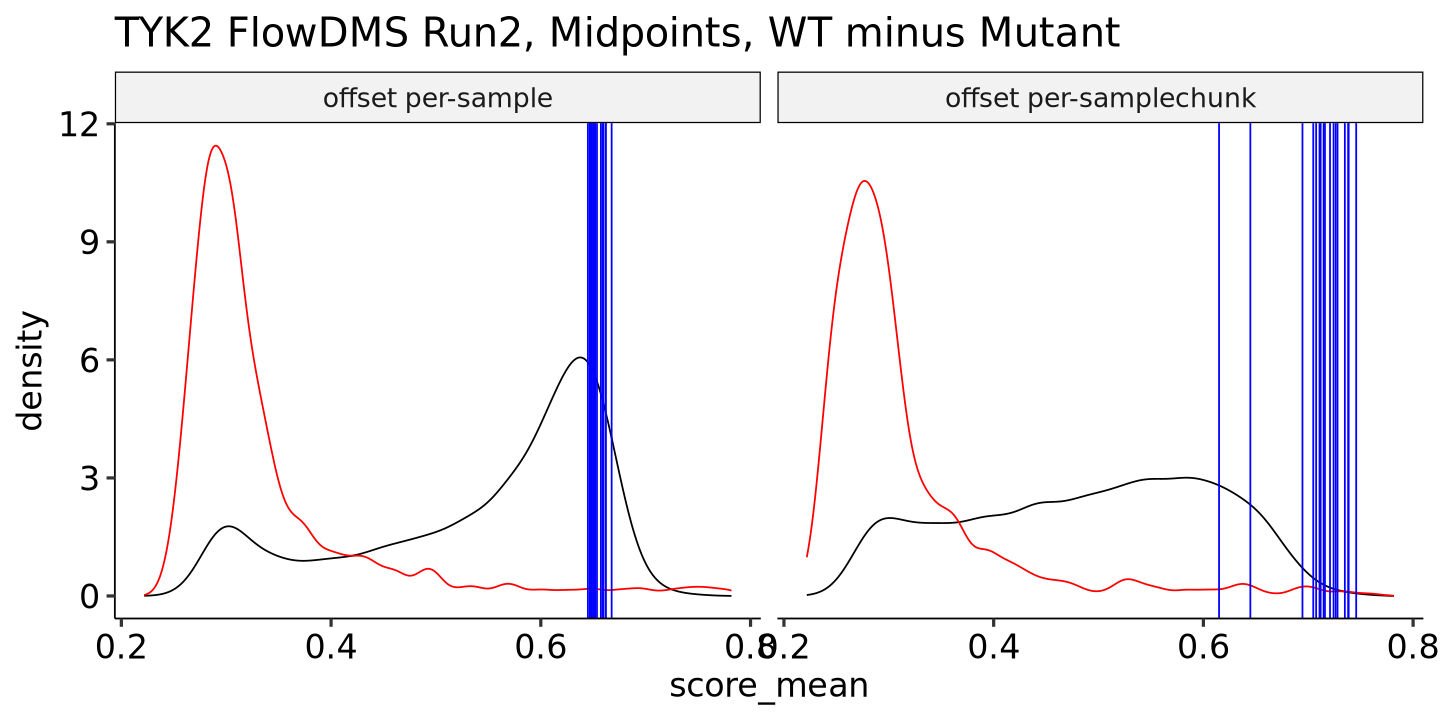

In [5]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(analyses) +
    geom_density(aes(x = score_mean,
                     color = case_when(mut_aa == "*" ~ "red",
                                       mut_aa == "WT" ~ "blue",
                                       TRUE ~ "black"))) +
    geom_vline(data = wt,
               aes(xintercept = score_mean,
                   group = group),
               color = "blue") +
    facet_wrap(~group, nrow = 1) +
    scale_color_identity() +
    theme_pubr(base_size = 20) +
    ggtitle("TYK2 FlowDMS Run2, Midpoints, WT minus Mutant") 

Clearly, the per-sample offset is much closer to the peak in the black distribution than in the per-samplechunk offset. For each version, if you compute the Z-statistic of the difference between each variant (in black or red) and its correspoding blue WT midpoint, you get these distributions:

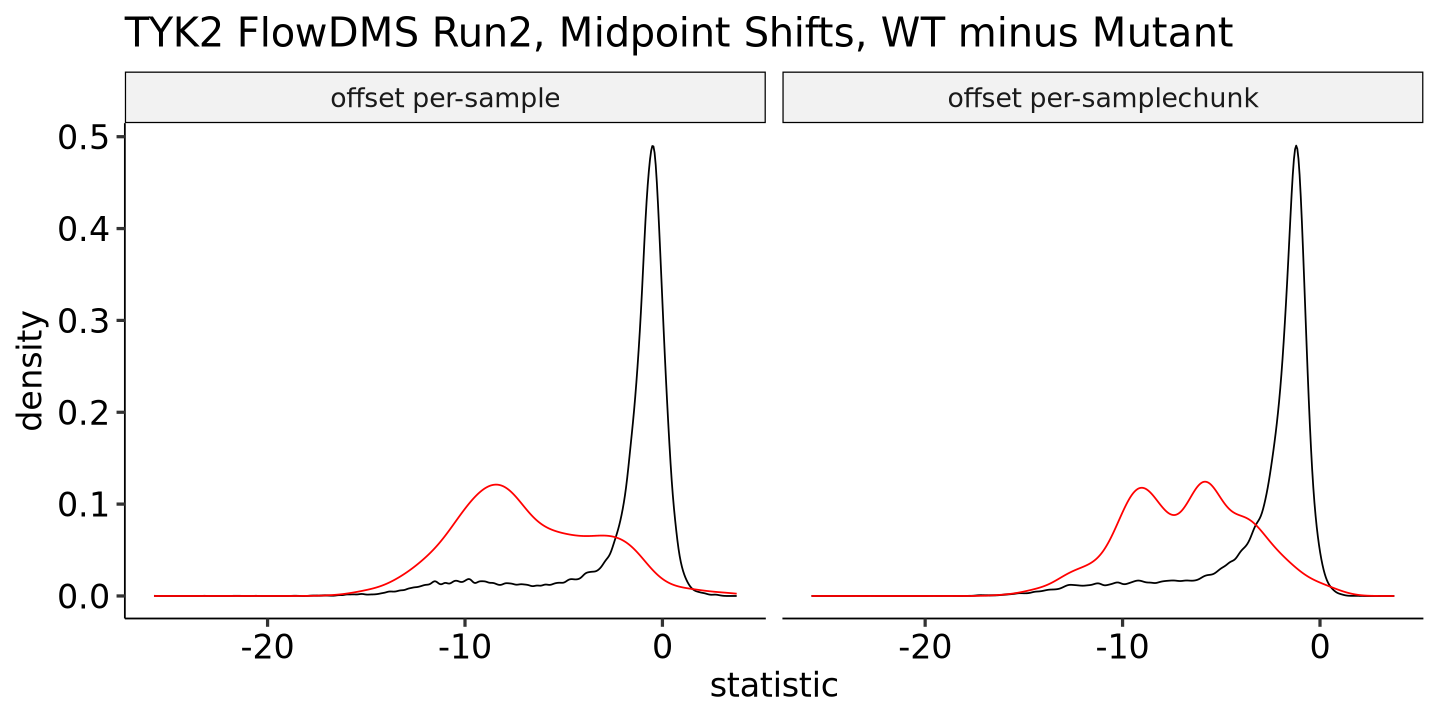

In [7]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(analyses) +
    geom_density(aes(x = statistic,
                     color = if_else(mut_aa == "*", "red", "black"))) +
    facet_wrap(~group, nrow = 1) +
    scale_color_identity() +
    theme_pubr(base_size = 20) +
    ggtitle("TYK2 FlowDMS Run2, Midpoint Shifts, WT minus Mutant")

This looks decent in general (and the stops are in the Z range we expect of -10 to -5), but if we zoom in, we see a problem:

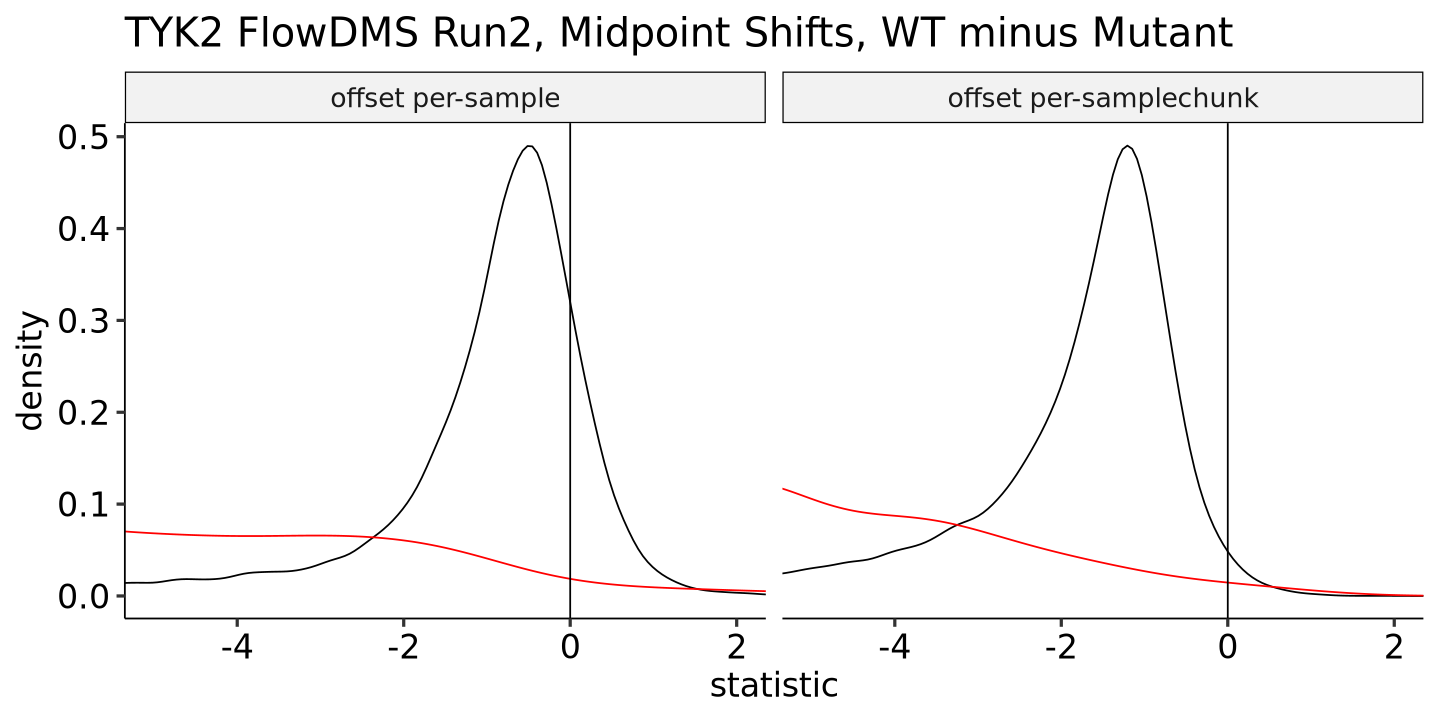

In [8]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(analyses) +
    geom_density(aes(x = statistic,
                     color = if_else(mut_aa == "*", "red", "black"))) +
    facet_wrap(~group, nrow = 1) +
    scale_color_identity() +
    theme_pubr(base_size = 20) +
    ggtitle("TYK2 FlowDMS Run2, Midpoint Shifts, WT minus Mutant") +
    coord_cartesian(xlim = c(-5, 2)) +
    geom_vline(xintercept = 0)

The Z-statsitics are systematically negative, when (in principle) the average variant should have no effect, and thus this distribution should peak at zero. However, it is clearly closer to zero per-sample instead of per-samplechunk.

To explore further, let's grab position 669, which contains a spike-in, and try different offsets to see what produces the best result.  We tried these seven models:

| Offset | Domain | 
| --- | --- |
| `log(sum(count))` | Per Sample |
| `log(sum(count))` | Per Sample-Chunk |
| `mean(log(count))` | Per Sample |
| `mean(log(count))` | Per Sample-Chunk |
| `log(sum(stop_count))` | Per Sample |
| `log(sum(stop_count))` | Per Sample-Chunk |
| None | NA |

In [9]:
mapped_counts <- data.table::fread("../../dms/pipeline/OCNT-VAMPLIB-1-assay-run2-all-assigned-split.mapped-counts.tsv",
        col.names = c("sample", "barcode", "count", "lib",
                      "chunk", "wt_aa", "pos", "mut_aa",
                      "wt_codon", "mut_codon", "chunkid", "dox",
                      "condition", "condition_conc", "clone")) %>%
    mutate(condition_conc = as.factor(condition_conc),
        mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
        mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    ungroup() %>%
    group_by(condition_conc) %>%
    mutate(log_stop_counts_sample = log(sum(count[which(mut_aa %in% c("*", "X", "Stop", "stop"))])),
        mean_log_count_sample = mean(log(count)),
        log_total_count_sample = log(sum(count))) %>%
    ungroup() %>%
    group_by(condition_conc, chunk) %>%
    mutate(log_stop_counts_chunk = log(sum(count[which(mut_aa %in% c("*", "X", "Stop", "stop"))])),
        mean_log_count_chunk = mean(log(count)),
        log_total_count_chunk = log(sum(count)))

pos669 <- mapped_counts %>%
    filter(pos == 669 | (mut_aa == "WT" & chunk == 10)) %>%
    mutate(condition_conc = as.factor(condition_conc),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

In [ ]:
container_list <- as.list(rep(NA, 7))
names(container_list) <- c(names(pos669)[16:21], "none")
for(i in 1:length(container_list)){
    container_list[[i]] <- run_model(pos669 %>% rename("offset_col" = names(container_list)[i]))
}
container_list[[7]] <- run_model(pos669 %>% mutate("offset_col" = 0))

In [ ]:
bind_rows(container_list, .id = "offset") %>%
    filter(mut_aa == "WT") %>%
    dplyr::select(offset, estimate, mut_aa, condition_conc) %>%
    group_by(offset) %>%
    mutate(condition_conc = as.numeric(condition_conc) / 100) %>%
    mutate(estimate = (estimate - min(estimate))/sum(estimate - min(estimate))) %>%
    summarize(mp = sum((condition_conc - 0.125)*estimate)) %>%
    arrange(-mp) %>%
    kable("markdown")

This recapitulates what we initially observed, namely that `mean(log(count))` per-sample seems to produce the best result. Surprisingly, the no-offset model seems to produce an even slightly lower result, which is presumably closer to the non-WT distribution peak.